<a href="https://colab.research.google.com/github/AndresPerelmuter/Clustering/blob/main/Cluster_H%26M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Objetivo**

---



# **Comprensión de los Datos**

---




In [1]:
! pip install pyclustertend
! pip install yellowbrick 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from plotly.offline import iplot
import plotly.graph_objs as go

from sklearn.metrics import pairwise_distances_argmin_min
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.spatial.distance import pdist, cdist
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

import warnings
warnings.filterwarnings("ignore")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Recopilación de Datos Iniciales**

In [4]:
transactions = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/transactions_train.csv")
articles = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/articles.csv")
customers = pd.read_csv("/content/drive/MyDrive/h-and-m-personalized-fashion-recommendations/customers.csv")

In [5]:
transactions.head(5)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


In [6]:
transactions.shape

(31788324, 5)

In [7]:
customers.head(5)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [8]:
customers.shape

(1371980, 7)

In [9]:
articles.head(5)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [10]:
articles.shape

(105542, 25)

In [11]:
transactions['n_trans'] = transactions['t_dat'] + transactions['customer_id']

In [12]:
tr1 = transactions.groupby(['n_trans'], as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)

In [13]:
tr1.sort_values(by=['Cantidad'], ascending=False)

,n_trans,Cantidad
330656,2018-10-14d00063b94dcb1342869d4994844a2742b5d6...,570
1161741,2018-12-17c2f0cdda2dc3042ccd9fcd8253fd8e368769...,336
1489900,2019-01-1362fd7d41b587c72a95c31eca5046019ce4e8...,221
333665,2018-10-15246734d8f4a4252fcd5c7aa525055a2804b9...,220
1869380,2019-02-1694665b46e194622ccdbcadc0170f13a2f8ed...,199
...,...,...
3097103,2019-05-2594a8ecbdfa06b79cad5dabf17f589dd3e343...,1
3097104,2019-05-2594abfdb4008c6694f0c81364300e970952db...,1
3097106,2019-05-2594b43cb3410386158516c9ade1bd05912d2e...,1
3097109,2019-05-2594bf4585813a3b38a52d7bfdefdc52b705b5...,1


**Exploración de los Datos**







In [14]:
transactions.describe()

,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00


In [15]:
transactions.dtypes

t_dat                object
customer_id          object
article_id            int64
price               float64
sales_channel_id      int64
n_trans              object
dtype: object

<AxesSubplot: ylabel='price'>

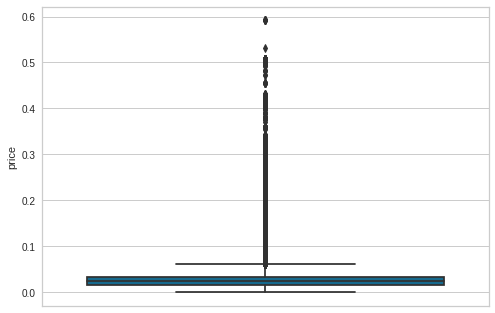

In [16]:
sns.boxplot(y = transactions['price'])

<AxesSubplot: xlabel='price', ylabel='Count'>

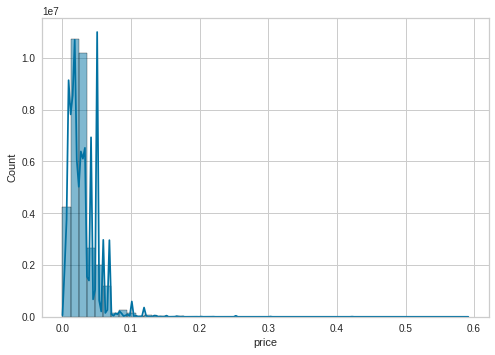

In [17]:
sns.histplot(data=transactions, x="price", palette='winter', bins=50, kde=True)

In [18]:
tr = transactions.groupby('article_id', as_index=False).agg(
    precio_promedio=('price', 'mean'),
    Min_Precio=('price', min),
    #porcentaje_min = (Min_Precio // precio_promedio),
    # Get min of the duration column for each group
    Max_Precio=('price', max))
tr

,article_id,precio_promedio,Min_Precio,Max_Precio
0,108775015,0.008142,0.001339,0.009153
1,108775044,0.008114,0.001424,0.008508
2,108775051,0.004980,0.003237,0.008458
3,110065001,0.020219,0.002525,0.025407
4,110065002,0.018205,0.004542,0.025407
...,...,...,...,...
104542,952267001,0.014982,0.010153,0.016932
104543,952938001,0.048006,0.040661,0.050831
104544,953450001,0.016836,0.015305,0.016932
104545,953763001,0.021908,0.021169,0.022017


En el cuadro debajo, se visualiza la cantidad de transacciones agrupada por día y cliente. Aqui se ven valores atipicos.

In [19]:
transactions['n_trans'] = transactions['t_dat'] + transactions['customer_id']
t_dia_clie = transactions.groupby(['n_trans'], as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)

In [20]:
t_dia_clie.sort_values(by=['Cantidad'], ascending=False)

,n_trans,Cantidad
330656,2018-10-14d00063b94dcb1342869d4994844a2742b5d6...,570
1161741,2018-12-17c2f0cdda2dc3042ccd9fcd8253fd8e368769...,336
1489900,2019-01-1362fd7d41b587c72a95c31eca5046019ce4e8...,221
333665,2018-10-15246734d8f4a4252fcd5c7aa525055a2804b9...,220
1869380,2019-02-1694665b46e194622ccdbcadc0170f13a2f8ed...,199
...,...,...
3097103,2019-05-2594a8ecbdfa06b79cad5dabf17f589dd3e343...,1
3097104,2019-05-2594abfdb4008c6694f0c81364300e970952db...,1
3097106,2019-05-2594b43cb3410386158516c9ade1bd05912d2e...,1
3097109,2019-05-2594bf4585813a3b38a52d7bfdefdc52b705b5...,1


In [21]:
t_dia_clie.shape

(9080179, 2)

<AxesSubplot: xlabel='Cantidad'>

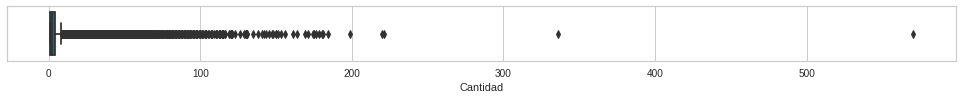

In [22]:
plt.figure(figsize=(17,1))
sns.boxplot(x = t_dia_clie['Cantidad'])

In [23]:
customers.describe()

,FN,Active,age
count,476930.0,464404.0,1.356119e+06
mean,1.0,1.0,3.638696e+01
std,0.0,0.0,1.431363e+01
min,1.0,1.0,1.600000e+01
25%,1.0,1.0,2.400000e+01
50%,1.0,1.0,3.200000e+01
75%,1.0,1.0,4.900000e+01
max,1.0,1.0,9.900000e+01


In [24]:
customers.dtypes

customer_id                object
FN                        float64
Active                    float64
club_member_status         object
fashion_news_frequency     object
age                       float64
postal_code                object
dtype: object

<AxesSubplot: ylabel='age'>

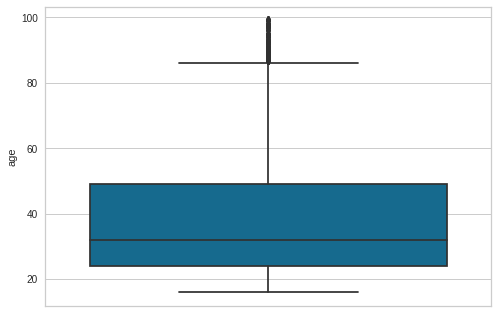

In [25]:
sns.boxplot(y = customers['age'])

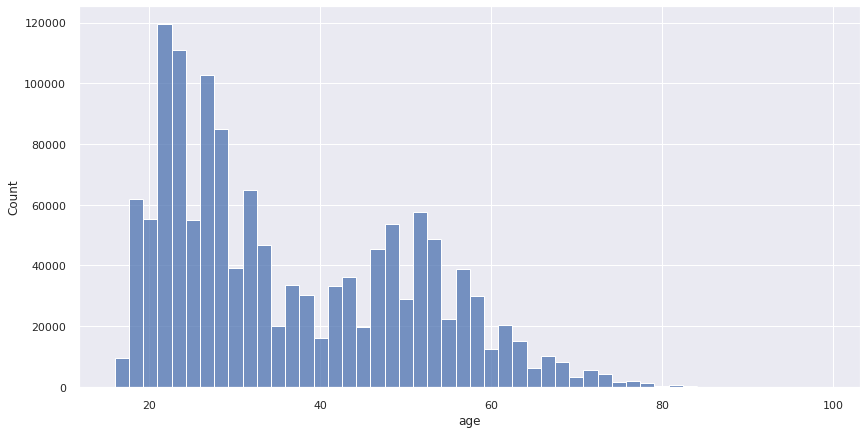

In [26]:
plt.figure(figsize=(14, 7))

sns.set(style="darkgrid")

sns.histplot(data=customers, x="age", bins=50)
plt.show()

In [27]:
articles.describe()

,article_id,product_code,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_group_no,section_no,garment_group_no
count,1.055420e+05,105542.000000,105542.000000,1.055420e+05,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000,105542.000000
mean,6.984246e+08,698424.563378,234.861875,1.009515e+06,32.233822,3.206183,7.807972,4532.777833,3.171534,42.664219,1010.438290
std,1.284624e+08,128462.384432,75.049308,2.241359e+04,28.086154,1.563839,5.376727,2712.692011,4.353234,23.260105,6.731023
min,1.087750e+08,108775.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000,1201.000000,1.000000,2.000000,1001.000000
25%,6.169925e+08,616992.500000,252.000000,1.010008e+06,9.000000,2.000000,4.000000,1676.000000,1.000000,20.000000,1005.000000
50%,7.022130e+08,702213.000000,259.000000,1.010016e+06,14.000000,4.000000,5.000000,4222.000000,2.000000,46.000000,1009.000000
75%,7.967030e+08,796703.000000,272.000000,1.010016e+06,52.000000,4.000000,11.000000,7389.000000,4.000000,61.000000,1017.000000
max,9.594610e+08,959461.000000,762.000000,1.010029e+06,93.000000,7.000000,20.000000,9989.000000,26.000000,97.000000,1025.000000


In [28]:
articles.dtypes

article_id                       int64
product_code                     int64
prod_name                       object
product_type_no                  int64
product_type_name               object
product_group_name              object
graphical_appearance_no          int64
graphical_appearance_name       object
colour_group_code                int64
colour_group_name               object
perceived_colour_value_id        int64
perceived_colour_value_name     object
perceived_colour_master_id       int64
perceived_colour_master_name    object
department_no                    int64
department_name                 object
index_code                      object
index_name                      object
index_group_no                   int64
index_group_name                object
section_no                       int64
section_name                    object
garment_group_no                 int64
garment_group_name              object
detail_desc                     object
dtype: object

In [29]:
art = articles.groupby('index_group_name', as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)
art

,index_group_name,Cantidad
2,Ladieswear,39737
0,Baby/Children,34711
1,Divided,15149
3,Menswear,12553
4,Sport,3392


### **Preparación de los Datos**

---



**Limpieza de Datos**

In [30]:
def missing_zero_values_table(df):
        zero_val = (df == 0.00).astype(int).sum(axis=0)
        mis_val = df.isnull().sum()
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
        mz_table = mz_table.rename(
        columns = {0 : 'Zero Values', 1 : 'Missing Values', 2 : '% of Total Values'})
        mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
        mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
        mz_table['Data Type'] = df.dtypes
        mz_table = mz_table[
            mz_table.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"      
            "There are " + str(mz_table.shape[0]) +
              " columns that have missing values.")
#         mz_table.to_excel('D:/sampledata/missing_and_zero_values.xlsx', freeze_panes=(1,0), index = False)
        return mz_table

In [31]:
def summarize_missing(df):
    # Null counts
    s1 = df.isnull().sum().rename('No. Missing')

    s2 = pd.Series(data=[df.index[m].tolist() for m in [df[col].isnull() for col in df.columns]],
                   index=df.columns,
                   name='Index')
    # Other way, probably overkill
    #s2 = (df.isnull().replace(False, np.NaN).stack().reset_index()
    #         .groupby('level_1')['level_0'].agg(list)
    #         .rename('Index'))

    return pd.concat([s1, s2], axis=1, sort=False)


In [32]:
def outliers(df):
    for col in df.columns:
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64')):
            percentiles = df[col].quantile([0.1,0.90]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]

In [33]:
summarize_missing(transactions)

,No. Missing,Index
t_dat,0,[]
customer_id,0,[]
article_id,0,[]
price,0,[]
sales_channel_id,0,[]
n_trans,0,[]


In [34]:
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

In [35]:
outliers(transactions)

In [36]:
t_dia_clie = transactions.groupby(['n_trans'], as_index=False).agg(Cantidad=('article_id', 'count')).sort_values(by=['Cantidad'], ascending=False)

Q1=t_dia_clie['Cantidad'].quantile(0.25)

Q3=t_dia_clie['Cantidad'].quantile(0.75)

IQR=Q3-Q1

print(Q3+3*IQR)

13.0


In [37]:
t_dia_clie= t_dia_clie[(t_dia_clie['Cantidad'] < 14)]

In [38]:
t_dia_clie.shape

(8868430, 2)

In [39]:
n_trans = t_dia_clie['n_trans'].tolist()

transactions = transactions[(transactions['n_trans'].isin(n_trans))]

In [40]:
transactions

,t_dat,customer_id,article_id,price,sales_channel_id,n_trans
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2,2018-09-20000058a12d5b43e67d225668fa1f8d618c13...
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2,2018-09-20000058a12d5b43e67d225668fa1f8d618c13...
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,541313006,0.015237,2,2018-09-2000007d2de826758b65a93dd24ce629ed6684...
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2,2018-09-2000007d2de826758b65a93dd24ce629ed6684...
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2,2018-09-2000007d2de826758b65a93dd24ce629ed6684...
...,...,...,...,...,...,...
31788319,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,846115002,0.050831,2,2020-09-22fff2282977442e327b45d8c89afde25617d0...
31788320,2020-09-22,fff2282977442e327b45d8c89afde25617d00124d0f999...,846115002,0.042356,2,2020-09-22fff2282977442e327b45d8c89afde25617d0...
31788321,2020-09-22,fff380805474b287b05cb2a7507b9a013482f7dd0bce0e...,846115002,0.043203,1,2020-09-22fff380805474b287b05cb2a7507b9a013482...
31788322,2020-09-22,fff4d3a8b1f3b60af93e78c30a7cb4cf75edaf2590d3e5...,833459002,0.010102,1,2020-09-22fff4d3a8b1f3b60af93e78c30a7cb4cf75ed...


In [41]:
summarize_missing(customers)

,No. Missing,Index
customer_id,0,[]
FN,895050,"[0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 16, 18, 2..."
Active,907576,"[0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 12, 16, 18, 2..."
club_member_status,6062,"[5, 844, 853, 908, 940, 1152, 1307, 1410, 1665..."
fashion_news_frequency,16009,"[5, 37, 197, 369, 398, 407, 604, 669, 832, 888..."
age,15861,"[5, 54, 99, 138, 148, 229, 290, 509, 592, 615,..."
postal_code,0,[]


In [42]:
customers['age']=customers['age'].fillna(customers['age'].mean())

In [43]:
customers['age'] = customers['age'].astype(np.int64)

In [44]:
summarize_missing(articles)

,No. Missing,Index
article_id,0,[]
product_code,0,[]
prod_name,0,[]
product_type_no,0,[]
product_type_name,0,[]
product_group_name,0,[]
graphical_appearance_no,0,[]
graphical_appearance_name,0,[]
colour_group_code,0,[]
colour_group_name,0,[]


In [45]:
outliers(articles)

In [46]:
aux1 = pd.merge(transactions[["customer_id", 'price', "sales_channel_id"]], customers[["customer_id",'age']])
aux1 = pd.DataFrame(aux1.groupby(['age', "sales_channel_id"], as_index=False).agg(ventas=('price', sum)))

# Create new dataframe column with the labels instead of numbers
aux1["sales_channel_id"] = aux1['sales_channel_id'].replace([1, 2], ['Store', 'Online'])
aux1.rename(columns={"sales_channel_id": "Canal Venta"}, inplace = True)
aux1['age'] = aux1['age'].astype('Int64', errors='ignore' )
aux1 = aux1[aux1.age < 70]

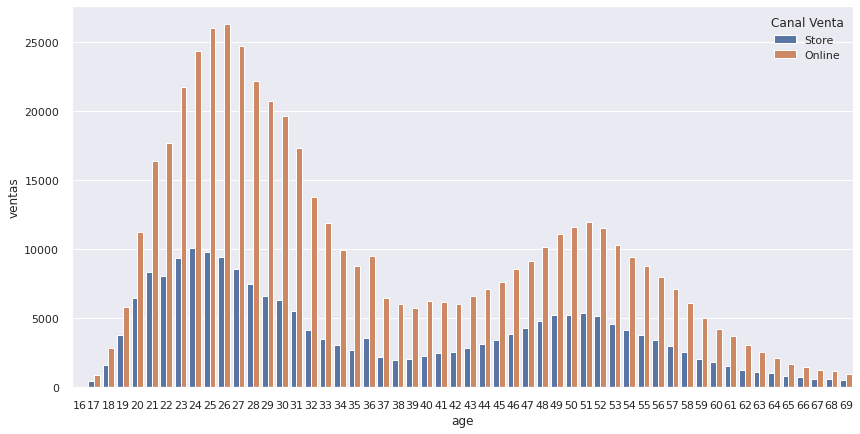

In [47]:
plt.figure(figsize=(14, 7))

bar1 = sns.barplot(x="age",  y="ventas", hue = 'Canal Venta', data=aux1, saturation=0.75, errcolor='.26')

plt.show()

In [48]:
aux = pd.merge(transactions[["article_id", 'price']], articles[["article_id",'index_group_name']])
aux = aux.groupby('index_group_name', as_index=False).agg(ventas=('price', sum))

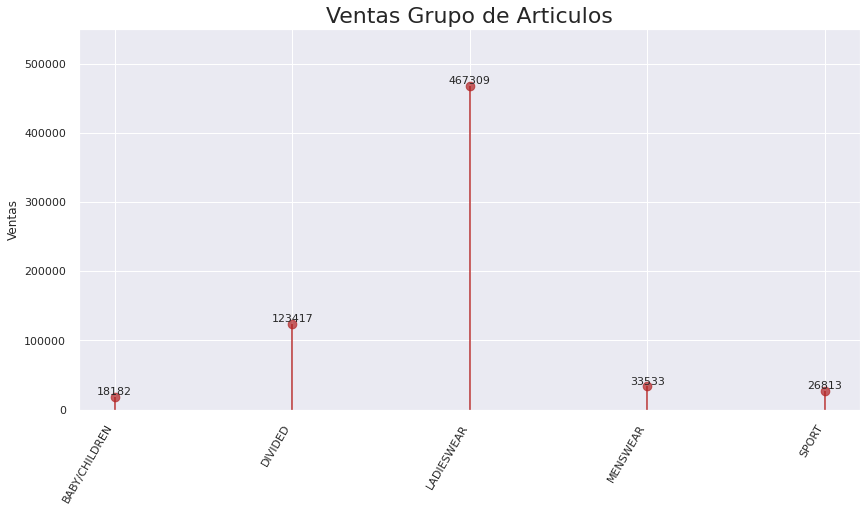

In [49]:
fig, ax = plt.subplots(figsize=(14,7))
ax.vlines(x=aux.index_group_name, ymin=0, ymax=aux.ventas, color='firebrick', alpha=0.7, linewidth=2)
ax.scatter(x=aux.index_group_name, y=aux.ventas, s=75, color='firebrick', alpha=0.7)

ax.set_title('Ventas Grupo de Articulos', fontdict={'size':22})
ax.set_ylabel('Ventas')
ax.set_xticks(aux.index_group_name)
ax.set_xticklabels(aux.index_group_name.str.upper(), rotation=60, fontdict={'horizontalalignment': 'right', 'size':11})
ax.set_ylim(0, 550000)


for row in aux.itertuples():
    ax.text(row.Index, row.ventas+.5, s=round(row.ventas), ha = 'center', va='bottom', fontsize=11)

plt.show()

In [50]:
aux3 = transactions.groupby(['t_dat', 'sales_channel_id'], as_index=False).agg(ventas=('price', sum))

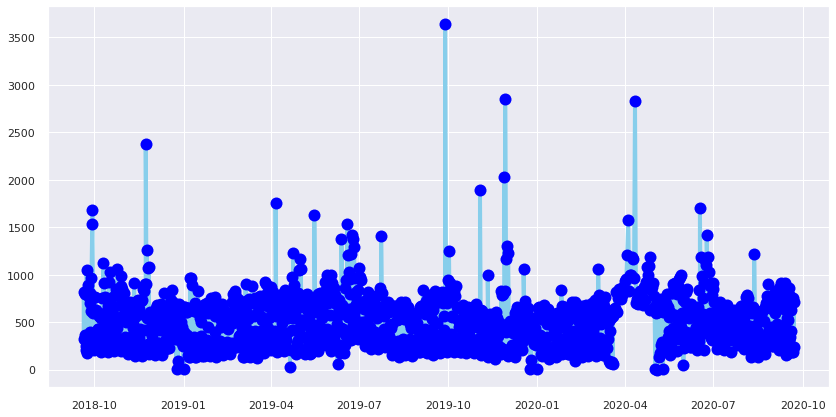

In [51]:
fig, ax = plt.subplots(figsize=(14,7))

plt.plot( 't_dat', 'ventas', data=aux3, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)

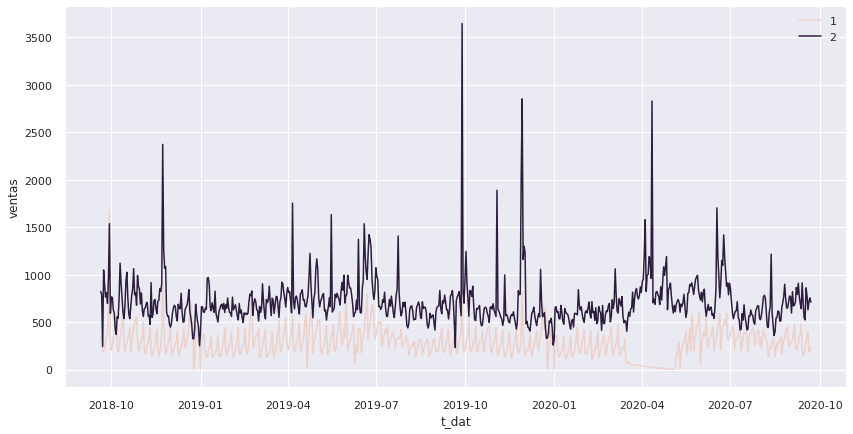

In [52]:
fig, ax = plt.subplots(figsize=(14,7))

# multiple line plots
sns.lineplot(data=aux3, x='t_dat', y='ventas', hue='sales_channel_id')
# show legend
plt.legend()

# show graph
plt.show()

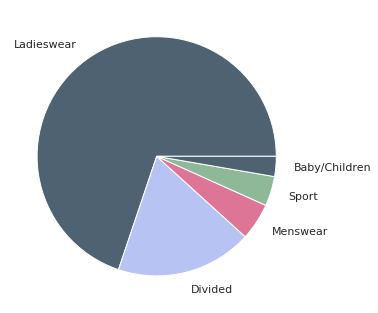

In [53]:
dfg = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name']], on="article_id", how='inner')
dfg = dfg.groupby('index_group_name', as_index=False).agg(ventas=('price', sum))
dfg = dfg.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfg.ventas, labels=dfg.index_group_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

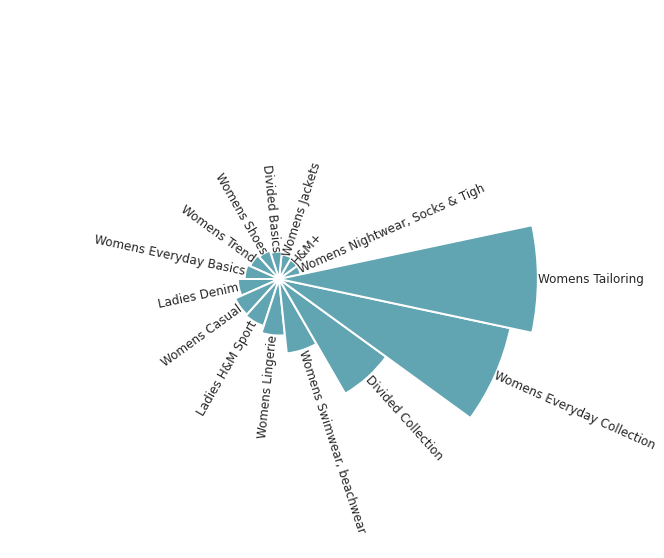

In [55]:
dfm = pd.merge(transactions[["article_id", 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfm = dfm.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfm = dfm.sort_values(by = 'ventas', ascending=False).head(15)

# Reorder the dataframe
dfm = dfm.sort_values(by=['ventas'])

# initialize the figure
plt.figure(figsize=(20,10))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 100
lowerLimit = 30
labelPadding = 4

# Compute max and min in the dataset
max = dfm['ventas'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * dfm.ventas + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(dfm.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(dfm.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color="#61a4b2",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, dfm["section_name"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

**Construcción de Datos**

In [56]:
df = transactions.groupby('customer_id').agg(
    precio_promedio=('price', 'mean'),
    compras_totales=('price', sum),
    cantidad_compras=('t_dat', 'nunique')
    # Get max of the duration column for each group
    ##fecha_ultima_compra=('t_dat', max),
    # Get min of the duration column for each group
    ##fecha_primer_compra=('t_dat', min),
    # Apply a lambda to date column
    ##antiguedad=("t_dat", lambda x: (max(x) - min(x)).days) 
)

In [57]:
df['promedio_dias_compra'] = transactions['previous_visit'] = transactions.groupby(['customer_id'])['t_dat'].shift()
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['t_dat'] - transactions['previous_visit']
df['promedio_dias_compra'] = transactions['days_bw_visits'] = transactions['days_bw_visits'].apply(lambda x: x.days)
df['promedio_dias_compra'] = transactions.groupby('customer_id')['days_bw_visits'].agg('mean')

df = pd.merge(df, customers[['customer_id','age']], on="customer_id", how = 'left')
df.fillna(axis=1, method="bfill").fillna(0)


,customer_id,precio_promedio,compras_totales,cantidad_compras,promedio_dias_compra,age
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.030581,0.642203,10,30.900000,49
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.029571,2.129085,22,9.239437,25
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.036235,0.652237,7,42.705882,24
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.030492,0.060983,1,0.000000,54
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0.035478,0.461220,6,55.833333,52
...,...,...,...,...,...,...
1352106,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.023759,0.784034,10,15.843750,24
1352107,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0.021321,1.790949,19,8.349398,21
1352108,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0.018214,0.819627,19,16.363636,21
1352109,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0.029886,0.209203,4,13.000000,18


In [58]:
df6 = transactions[['customer_id','sales_channel_id']]
df6["sales_channel_id"] = df6['sales_channel_id'].replace([1, 2], ['Store', 'Online'])
df6 = df6.pivot_table(index='customer_id', columns='sales_channel_id', aggfunc=len, fill_value=0)

In [59]:
temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_name']], on="article_id", how='inner')
temp = temp.dropna()
ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_name)
ca_matrix = pd.DataFrame(ca_matrix)

In [60]:
df8 = pd.merge(ca_matrix, df, on='customer_id')
df8 = pd.merge(df8, df6, on='customer_id')
df8


,customer_id,Baby/Children,Divided,Ladieswear,Menswear,Sport,precio_promedio,compras_totales,cantidad_compras,promedio_dias_compra,age,Online,Store
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,5,1,14,0,0,0.030581,0.642203,10,30.900000,49,12,9
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,4,17,46,0,0,0.029571,2.129085,22,9.239437,25,67,5
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0,0,12,2,1,0.036235,0.652237,7,42.705882,24,18,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0,0,0,0,2,0.030492,0.060983,1,0.000000,54,2,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0,0,9,0,2,0.035478,0.461220,6,55.833333,52,11,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326311,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0,0,27,1,4,0.023759,0.784034,10,15.843750,24,20,13
1326312,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,7,44,29,2,0,0.021321,1.790949,19,8.349398,21,56,28
1326313,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0,16,16,4,1,0.018214,0.819627,19,16.363636,21,34,11
1326314,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0,2,5,0,0,0.029886,0.209203,4,13.000000,18,6,1


In [ ]:
df8['cantidad_compras'].mean()

In [66]:
# selecting numerical columns
num_cols = df8[['Baby/Children', 'Divided','Ladieswear', 'Menswear', 'Sport', 'precio_promedio', 'promedio_dias_compra', 'age', 'Online', 'Store']]
#num_cols = df8.select_dtypes(include=np.number).columns.tolist()

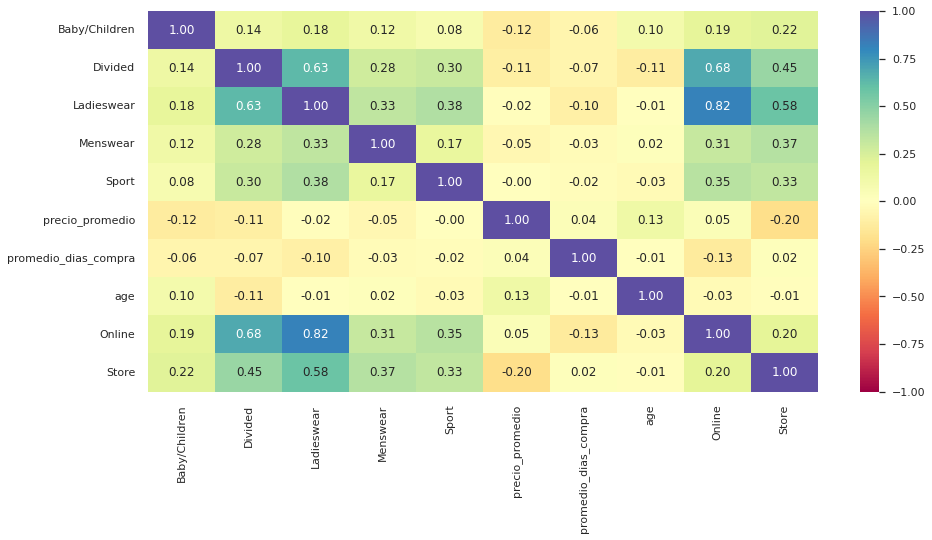

In [67]:
# check for correlations

plt.figure(figsize=(15, 7))
sns.heatmap(
    num_cols.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

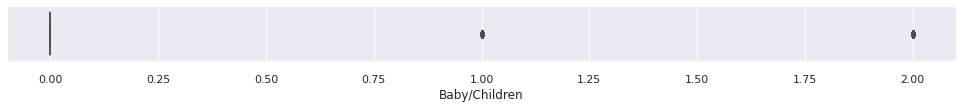

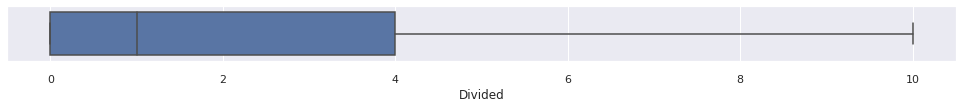

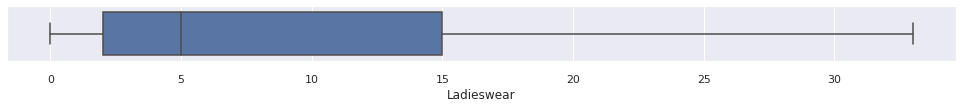

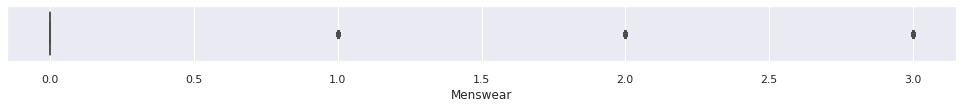

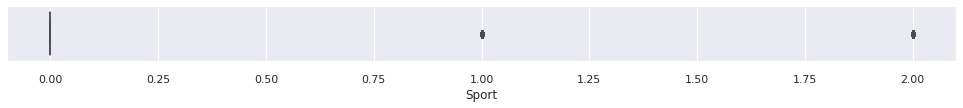

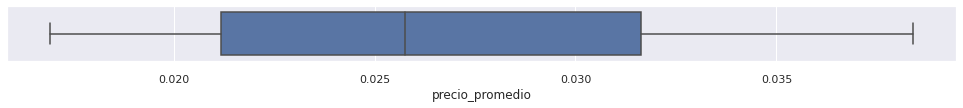

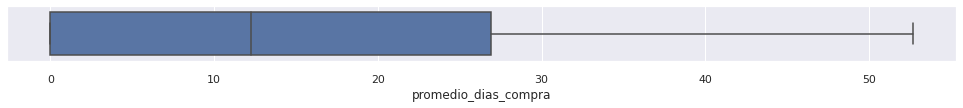

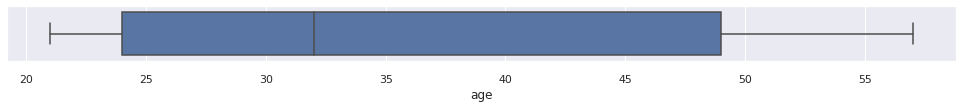

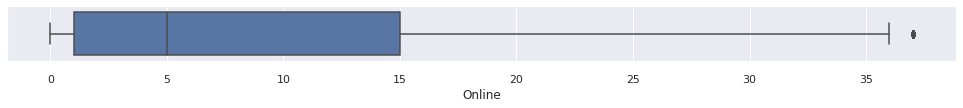

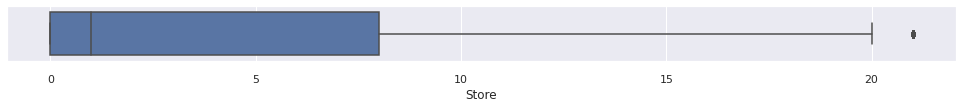

In [68]:
for column in num_cols:
        plt.figure(figsize=(17,1))
        sns.boxplot(data=num_cols, x=column)

In [64]:
#sns.pairplot(num_cols,diag_kind="kde")

In [69]:
outliers(df8)

In [ ]:
df8.shape

(1326316, 13)

# **Modelado**

---



In [70]:
dfcluster = num_cols
dfcluster = dfcluster.dropna()

In [71]:
scaler = StandardScaler()
dfcluster = scaler.fit_transform(dfcluster)

In [ ]:
# define the model
model = Birch()
# fit the model
model.fit(dfcluster)
# assign a cluster to each example
yhat = model.predict(dfcluster)
# retrieve unique clusters
clusters = unique(yhat)

In [72]:
from pyclustertend import hopkins
hopkins(dfcluster,150)

0.1386654613953223

In [ ]:
# k means determine k
distortions = []
K = range(3,12)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(dfcluster)
    kmeanModel.fit(dfcluster)
    distortions.append(sum(np.min(cdist(dfcluster, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / dfcluster.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

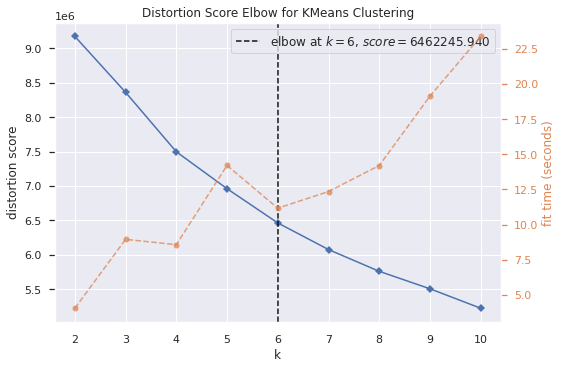

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [73]:
kmeanModel = KMeans()
elb_visualizer = KElbowVisualizer(kmeanModel, k=(2,11))
elb_visualizer.fit(dfcluster)    
elb_visualizer.show() 

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4))
visualizer.fit(dfcluster)    
visualizer.show()

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer7 = SilhouetteVisualizer(KMeans(7, random_state = 1))
visualizer7.fit(dfcluster)    
visualizer7.show();

In [ ]:
# Finding optimal no. of clusters with silhouette coefficients
visualizer8 = SilhouetteVisualizer(KMeans(8, random_state = 1))
visualizer8.fit(dfcluster)    
visualizer8.show();

In [ ]:
dfcluster = pd.DataFrame(dfcluster)

In [74]:
# Para el ejercicio, elijo 5 como un buen valor de K. Pero podría ser otro.
kmeans = KMeans(n_clusters=6).fit(dfcluster)
predict=kmeans.predict(dfcluster)
#dfcluster['Pred'] = kmeans.predict

In [75]:
df8 = df8.dropna()
df8["Cluster"] = kmeans.labels_

In [ ]:
cluster2 = df8[df8['antiguedad'] ==0] 
cluster2 = cluster2[cluster2['Cluster'] == 2]
cluster2

In [76]:
results = df8.groupby(['Cluster'], as_index = False).agg(
    Cantidad=('customer_id', 'count'),    
    precio_promedio=('precio_promedio', 'mean'),
    compras_totales=('compras_totales', sum),    
    #antiguedad=('antiguedad', 'mean'),
    #min_antiguedad=('antiguedad', 'min'),
    #max_antiguedad=('antiguedad', 'max'),    
    promedio_dias_compras=('promedio_dias_compra', 'mean'),  
    age=('age', 'mean'),
    store=('Store', 'mean'),
    online=('Online', 'mean'),
    baby_children=('Baby/Children', 'mean'),
    Ladieswear	=('Ladieswear', 'mean'),  
    Menswear=('Menswear', 'mean'),
    Sport=('Sport', 'mean'),       
)

In [77]:
results

,Cluster,Cantidad,precio_promedio,compras_totales,promedio_dias_compras,age,store,online,baby_children,Ladieswear,Menswear,Sport
0,0,216242,0.033983,54908.092250,6.189092,40.900214,1.214778,6.103944,0.022151,4.978973,0.255820,0.179498
1,1,101820,0.023616,42193.610623,16.312179,40.320507,7.096189,8.868660,1.930623,7.765616,0.433834,0.216657
2,2,276742,0.021137,40380.445191,4.914808,31.995241,1.915391,5.020246,0.025865,4.276048,0.197213,0.114796
3,3,155054,0.023784,113250.708547,19.294136,34.763341,17.337302,7.833452,0.159177,17.610362,1.258452,0.743792
4,4,207332,0.027292,254696.452627,10.693124,35.042270,9.184318,33.951908,0.481643,28.174889,1.155832,0.929910
5,5,250790,0.027056,62062.245356,44.561349,35.389573,3.217748,5.994796,0.043116,5.768276,0.279082,0.240237


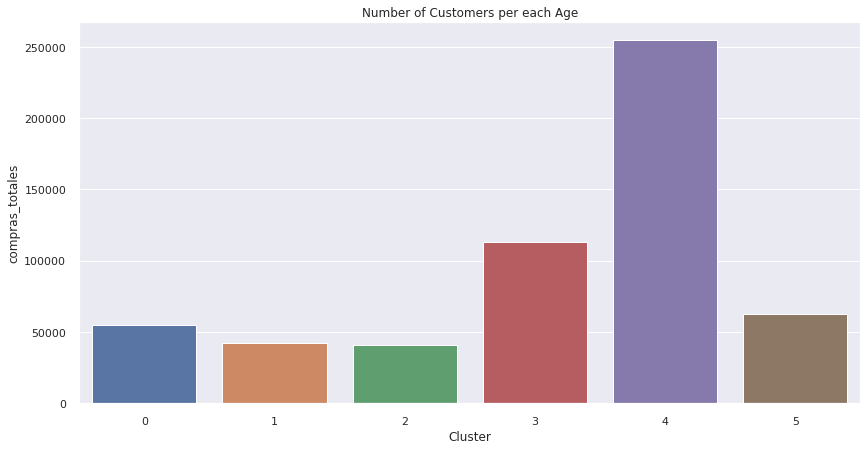

In [78]:
plt.figure(figsize = (14,7))
plt.title(f'Number of Customers per each Age')
sns.set_color_codes("pastel")
sns.barplot(x = 'Cluster', y="compras_totales", data=results)

plt.show()

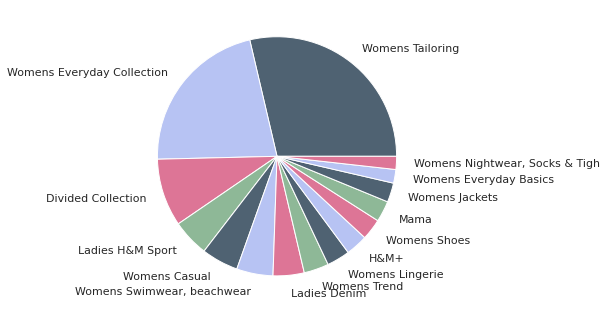

In [79]:
dfcluster0 = df8[df8['Cluster']==0]
dfcluster0 = pd.merge(dfcluster0[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster0 = pd.merge(dfcluster0[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster0 = dfcluster0.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster0 = dfcluster0.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster0.ventas, labels=dfcluster0.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

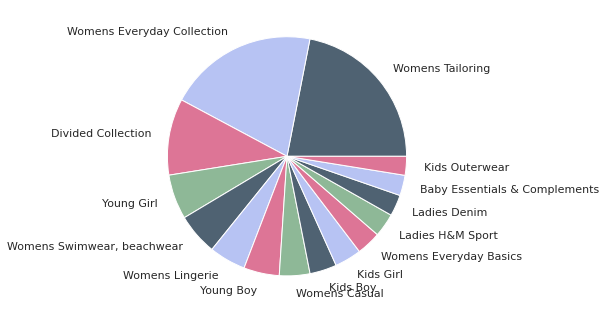

In [80]:
dfcluster1 = df8[df8['Cluster']==1]
dfcluster1 = pd.merge(dfcluster1[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster1 = pd.merge(dfcluster1[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster1 = dfcluster1.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster1 = dfcluster1.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster1.ventas, labels=dfcluster1.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

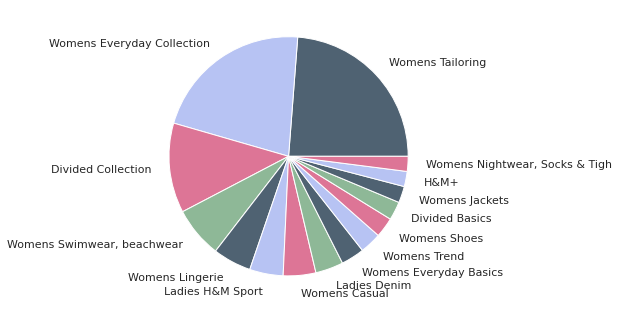

In [81]:
dfcluster2 = df8[df8['Cluster']==2]
dfcluster2 = pd.merge(df8[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster2 = pd.merge(dfcluster2[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster2 = dfcluster2.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster2 = dfcluster2.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster2.ventas, labels=dfcluster2.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

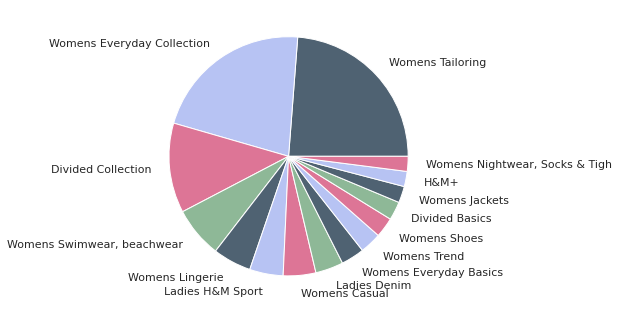

In [82]:
dfcluster3 = df8[df8['Cluster']==3]
dfcluster3 = pd.merge(df8[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster3 = pd.merge(dfcluster3[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster3 = dfcluster3.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster3 = dfcluster3.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster3.ventas, labels=dfcluster3.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

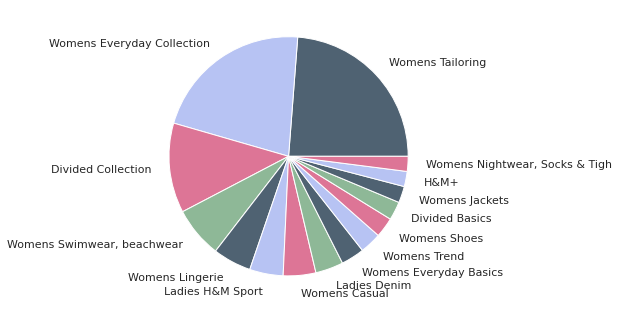

In [83]:
dfcluster4 = df8[df8['Cluster']==4]
dfcluster4 = pd.merge(df8[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster4 = pd.merge(dfcluster4[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster4 = dfcluster4.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster4 = dfcluster4.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster4.ventas, labels=dfcluster4.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

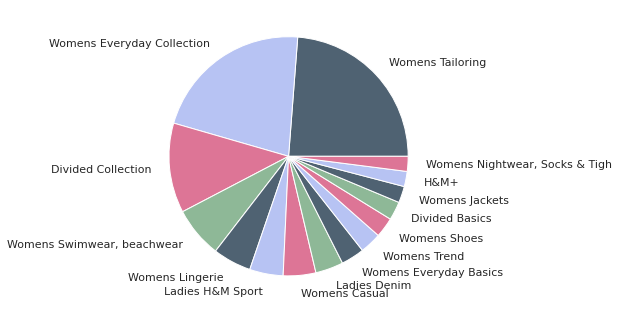

In [85]:
dfcluster5 = df8[df8['Cluster']==5]
dfcluster5 = pd.merge(df8[['customer_id', "Cluster"]], transactions[['customer_id','article_id', 'price']], on="customer_id", how='inner')

dfcluster5 = pd.merge(dfcluster5[['customer_id', "Cluster", 'article_id', 'price']], articles[['article_id','index_group_name', 'section_name']], on="article_id", how='inner')
dfcluster5 = dfcluster5.groupby('section_name', as_index=False).agg(ventas=('price', sum))
dfcluster5 = dfcluster5.sort_values(by = 'ventas', ascending=False).head(15)

# Create a set of colors
colors = ['#4F6272', '#B7C3F3', '#DD7596', '#8EB897']

# Use it thanks to the color argument
plt.pie(dfcluster5.ventas, labels=dfcluster5.section_name, labeldistance=1.15, wedgeprops = { 'linewidth' : 1, 'edgecolor' : 'white' }, colors=colors);

NameError: ignored

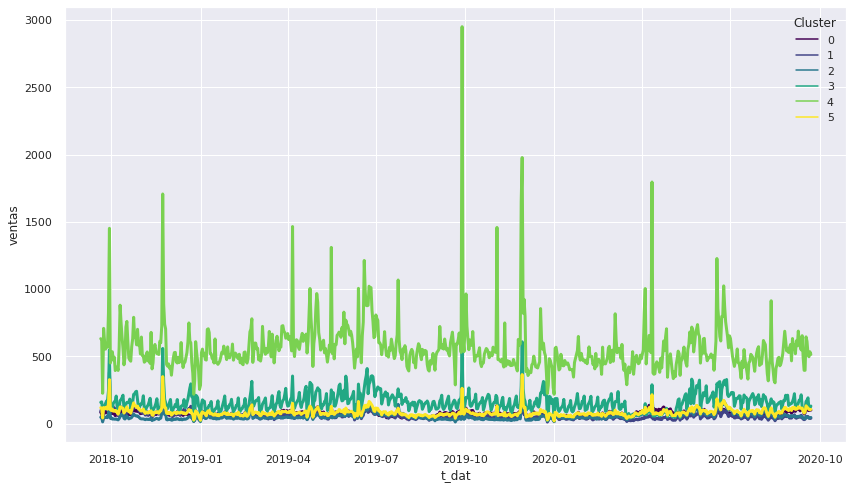

In [89]:
aux5 = pd.merge(transactions[["customer_id", 't_dat', 'price' ]], df8[["customer_id",'Cluster']], on="customer_id", how='inner')
aux5 = aux5.groupby(['t_dat', 'Cluster'], as_index=False).agg(ventas=('price', sum))

sns.set_style('darkgrid')
sns.set(rc={'figure.figsize':(14,8)})

ax = sns.lineplot(data=aux5, x ='t_dat', y = 'ventas',
                  hue='Cluster', palette='viridis',
                  legend='full', lw=3)

ax.xaxis.set_major_locator(ticker.MultipleLocator(4))
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('PM2.5 (µg/m3)')
plt.xlabel('Year-Month')
plt.show()


In [94]:
list_cluster = list(set(df8['Cluster']))

import plotly.graph_objects as go

#extract color palette, the palette can be changed
pal = list(sns.color_palette(palette='viridis', n_colors=len(list_cluster)).as_hex())

fig = go.Figure()
for d,p in zip(list_cluster, pal):
    fig.add_trace(go.Scatter(x = aux5[aux5['Cluster']==d]['t_dat'],
                             y = aux5[aux5['Cluster']==d]['ventas'],
                             name = d,
                             line_color = p, 
                             fill=None))   #tozeroy 

fig.show()

In [ ]:
sns.boxplot(data = df8, x="Cluster", y="Menswear")

In [ ]:
sns.boxplot(data = df8, x="Cluster", y="promedio_dias_compra")

In [ ]:
plt.figure(figsize = (16,6))
plt.title(f'Number of Customers per each Age')
sns.set_color_codes("pastel")
s = sns.barplot(x = '', y="compras_totales", data=df8)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
locs, labels = plt.xticks()
plt.show()

In [ ]:
cluster_profile = df.groupby('K_means_segments').mean()

In [ ]:
# Obtenemos las etiquetas de cada punto de nuestros datos
labels = kmeans.predict(X)
# Obtenemos los centroids
C = kmeans.cluster_centers_
colores=['red','green','blue','cyan','yellow']
asignar=[]
for row in labels:
    asignar.append(colores[row])

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=asignar,s=60)
ax.scatter(C[:, 0], C[:, 1], C[:, 2], marker='*', c=colores, s=1000)

In [ ]:
#articles['article_id'] = articles['article_id'].astype(str)
articles['index_group_no'] = articles['index_group_no'].astype(str)
#transactions['article_id'] = transactions['article_id'].astype(str)

In [ ]:
temp = pd.merge(transactions[["customer_id", "article_id"]], articles[['article_id','index_group_no']], on="article_id", how='inner')

# check null values and drop it.
display(temp[temp.isnull().any(axis=1)])

temp = temp.dropna()

ca_matrix = pd.crosstab(index=temp.customer_id, columns=temp.index_group_no)
ca_matrix

In [ ]:
temp

In [ ]:
temp.dtypes

In [ ]:
transactions = transactions[["customer_id", "article_id", "price"]]
customers = customers[["customer_id", "age"]]
articles = articles[["article_id", "prod_name", "product_type_name", "product_group_name",
                     "department_name", "index_name", "index_group_name",
                     "section_name", "garment_group_name"]]



In [ ]:
temp = pd.merge(transactions, articles, on="article_id", how='inner')
temp = pd.merge(temp, customers, on="customer_id", how='inner')
temp

# **Conclusión**

---

